# Convolutional Neural Network (CNN) from scratch
#### adapted from Keras_CNN code and Keras_CNN_Tensorboard

### Import libraries - make sure kernel is Python 3

In [1]:
# IF RUNNING FOR THE FIRST TIME ON AWS
#!pip3 install pillow

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD, Adam
from keras import backend as K
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#import PIL
from PIL import Image
import pandas as pd
import random
from keras.callbacks import TensorBoard

Using TensorFlow backend.


### Set seed

In [2]:
np.random.seed()

### Import data

In [3]:
data = pd.read_csv('id_genre_pairs.csv')
movie_ids = list(data['movie_id'])
data = np.array(data)


In [4]:
def convert_data_to_size(width,height):
    ####Convert Data to same size 
    for row in data:
        try:
            img = Image.open('Movie Posters/'+str(row[0])+'.jpg')
            img = img.resize((width,height), PIL.Image.ANTIALIAS)
            img.save('Movie Posters Resized '+str(width)+"x"+str(height)+'/'+str(row[0]) + ".jpg", "JPEG")
        except:
            pass


In [5]:
import os
files = [i for i in os.listdir('Movie Posters Resized 32x32') if i[-3:] == 'jpg']
random.shuffle(files)

training_indices = files[:int(len(files)*0.8)]
test_indices = files[int(len(files)*0.8):]

test = []
test_labels = []
for i in test_indices:
    try:
        img = load_img('Movie Posters Resized 32x32/'+i)
        test.append(img_to_array(img))
        idx = int(i[:i.index(".")])
        for row in data:
            if row[0] == idx:
                test_labels.append(row[1:])
                break
    except:
        pass
    

In [7]:
train = []
train_labels = []
for i in training_indices:
    #try:
    img = load_img('Movie Posters Resized 32x32/'+i)
    train.append(img_to_array(img))
    idx = int(i[:i.index(".")])
    for row in data:
        if row[0] == idx:
            train_labels.append(row[1:])
            break
    #except:
        #pass


### Reshape data to tell Keras there is only one channel

In [8]:
img_rows, img_cols = 32, 32
num_classes = 17

x_train = np.array(train) 
x_test = np.array(test)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

### Normalize images to [0,1]

In [9]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

# interestingly the keras example code does not center the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (11757, 32, 32, 3)
x_test shape: (2940, 32, 32, 3)
11757 train samples
2940 test samples


### Create the network structure

In [14]:
keras.backend

<module 'keras.backend' from '/home/ubuntu/.local/lib/python3.5/site-packages/keras/backend/__init__.py'>

In [22]:
import keras.backend as K

import keras.backend as K

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [23]:
from sklearn.metrics import hamming_loss

In [39]:
import keras.backend as K
def accuracy_with_threshold(y_true, y_pred):
    threshold = 0.1
    y_pred = K.cast(K.greater(y_pred, threshold), K.floatx())
    return K.mean(K.equal(y_true, y_pred))

# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 256
#batch_size=512 # Just for running locally - change this!
# number of iterations over the complete training data
#epochs = 50
epochs=10 # Just for running locally - change this!
for n_conv_layers in [1,2]:
    for n_dense_layers in [1,2]:
        log_dir_string = "cv"
        K.clear_session()
        model = Sequential()
        model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        if n_conv_layers == 1:
            log_dir_string += "_1conv"
        else:
            model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            log_dir_string += "_2conv"
        
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        if n_dense_layers == 1:
            log_dir_string += "_1fc"
        else:
            model.add(Dense(64, activation='relu'))
            log_dir_string += "_2fc"
        
        model.add(Dense(num_classes, activation='sigmoid'))
        
        #sgd = SGD(lr=0.1, momentum=0.9)
        #model.compile(loss='binary_crossentropy',
        #      optimizer=sgd,
        #      metrics=['accuracy'])
        adam = Adam(lr=0.001)
        model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy',accuracy_with_threshold, precision])

        # we need a callback to save information for tensorboard visualizations
        tensorboard = TensorBoard(log_dir='./logs/cv/'+log_dir_string, histogram_freq=1, write_graph=True, write_images=False)

        history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[tensorboard])
        

        score = model.evaluate(x_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

Train on 11757 samples, validate on 2940 samples
INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.
INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.
INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.
Epoch 1/10
11757/11757 [==============================] - 1s - loss: 0.3111 - acc: 0.8887 - accuracy_with_threshold: 0.6224 - precision: 0.1221 - val_loss: 0.2534 - val_acc: 0.9180 - val_accuracy_with_threshold: 0.6992 - val_precision: 0.0000e+00

In [36]:
predictions = (predictions>0.1).astype(int)
predictions[3]

array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [46]:
precision_score(y_test, predictions, average="micro")
#precision_score(y_test, predictions, average="macro")

0.18149047303759289

In [38]:
from sklearn.metrics import precision_score
predictions = (model.predict(x_test)>0.1).astype(int)
predictions
all_precisions = []
for i in range(17):
    all_precisions.append(precision_score(y_test[:,i], predictions[:,i]))
all_precisions = np.array(all_precisions)
all_precisions.mean()


0.085070822251956155

### Visualize accuracy as a function of training epoch

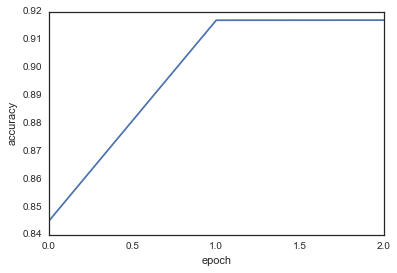

In [44]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

### Get the weights from the first layer and visualize

Shape of W
(5, 5, 3, 16)


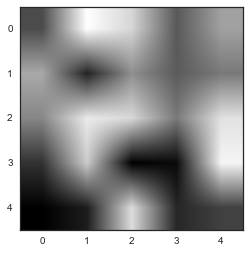

In [45]:
# Look at the weights of the first layer
layer = model.layers[0]
# this actually returns a list 
# first element is W
# second element are all the biases b
weights = layer.get_weights()
# the weights are the number of pixels times the number of filters (hidden units)
print("Shape of W")
print(weights[0].shape)

# look at just the first filter
w = weights[0][:,:,0,0]
w = w.reshape((5,5))
plt.imshow(w, cmap='gray')

### Visualize the weights from the first 25 filters

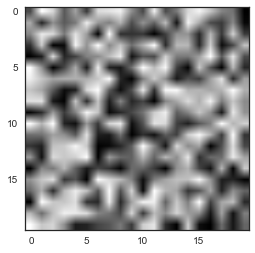

In [46]:
# make a figure for the first 25 filters
filterTiles = np.array([])
index = 0
for i in range(4):
    filterRow = []
    for j in range(4):
        w = weights[0][:,:,0,index]
        w = w.reshape(5,5)
        w = w-np.min(w)
        w = w / np.max(w)
        filterRow.extend(w)
        index+=1
    filterRow = np.array(filterRow)
    if not filterTiles.shape[0] == 0:
        filterTiles = np.hstack([filterTiles, filterRow])
    else:
        filterTiles = filterRow

plt.imshow(filterTiles, cmap='gray')    
plt.show()



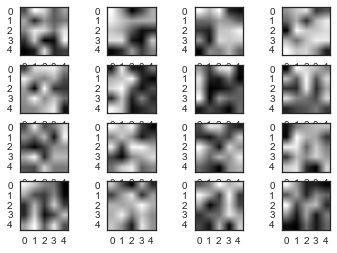

In [47]:
# make a figure for the first 25 filters
index = 0
for i in range(4):
    for j in range(4):
        w = weights[0][:,:,0,index]
        w = w.reshape(5,5)
        index+=1
        plt.subplot(4,4,index)
        plt.imshow(w, cmap='gray')    

plt.show()